C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A valu

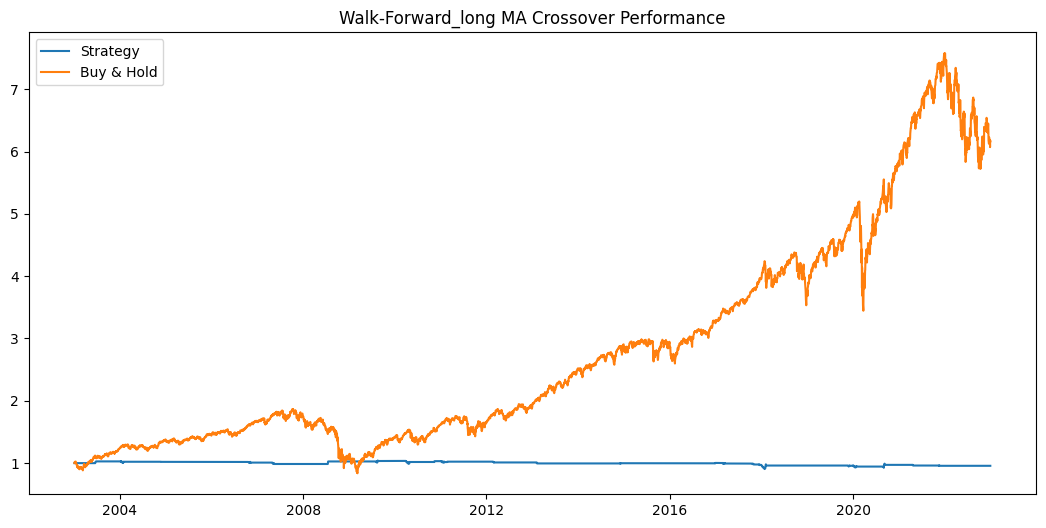

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

asset_list = [
    "SPY", "QQQ", "DIA",
    "EWJ", "EEM", "VGK",
    "TLT", "IEF", "BND",
    "GLD", "SLV", "USO",
    "EURUSD=X", "JPY=X", "AUDUSD=X",
    "BTC-USD", "ETH-USD"
]


OVERBOUGHT = 70
OVERSOLD = 30


def get_data(ticker):
    df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
    df.columns = df.columns.get_level_values(0)
    df = df[['Close']].dropna()
    return df

def apply_strategy(df, period=14, window=20, num_std=2):
    df = df.copy()
    
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    # Wilder's smoothing
    avg_gain = avg_gain.shift(1).ewm(alpha=1/period, adjust=False).mean()
    avg_loss = avg_loss.shift(1).ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi.fillna(50)

    df['BB_MA'] = df['Close'].rolling(window=window).mean()
    df['BB_Std'] = df['Close'].rolling(window=window).std()
    df['BB_Upper'] = df['BB_MA'] + (num_std * df['BB_Std'])
    df['BB_Lower'] = df['BB_MA'] - (num_std * df['BB_Std'])

    df['RSI_Strategy'] = 0
    df.loc[df['RSI'] > OVERBOUGHT, 'RSI_Strategy'] = -1
    df.loc[df['RSI'] < OVERSOLD, 'RSI_Strategy'] = 1
    
    df['BB_Strategy'] = 0
    df.loc[df['Close'] > df['BB_Upper'], 'BB_Strategy'] = -1
    df.loc[df['Close'] < df['BB_Lower'], 'BB_Strategy'] = 1

    df['signal'] = 0

    agree_long  = (df['RSI_Strategy'] == 1) & (df['BB_Strategy'] == 1)
    agree_short = (df['RSI_Strategy'] == -1) & (df['BB_Strategy'] == -1)
    
    # 1. If both indicators agree
    df.loc[agree_long, 'signal'] = 1
    df.loc[agree_short, 'signal'] = -1

    # 2. If they disagree but RSI has a signal
    df.loc[(df['signal'] == 0) & (df['RSI_Strategy'] != 0), 'signal'] = df['RSI_Strategy']

    df['signal'] = df['signal'].shift(1)            # trade next day
    df['signal'].fillna(0, inplace=True)

    # daily returns
    df['ret'] = df['Close'].pct_change().fillna(0)

    # strategy returns
    df['strategy_ret'] = df['signal'] * df['ret']

    return df[['signal','strategy_ret', 'ret']]

def walk_forward(df, train_years=3, test_years=1, window=20):

    df = df.copy()
    df = df.sort_index() 
    results = []

    start = df.index.min()

    while True:
        train_start = start
        train_end = train_start + pd.DateOffset(years=train_years)
        test_end = train_end + pd.DateOffset(years=test_years)

        # break if test window exceeds data
        if test_end > df.index.max():
            break

        # slice windows
        train = df[(df.index >= train_start) & (df.index < train_end)].copy()
        test = df[(df.index >= train_end) & (df.index < test_end)].copy()

        # if too small skip
        if len(train) < window + 5:
            start = start + pd.DateOffset(years=test_years)
            continue

        # train + test combined for MA calculation
        combined = pd.concat([train, test]).sort_index()

        # apply strategy
        window_results = apply_strategy(combined, window=window)

        # keep only test window results
        window_results = window_results.loc[test.index]

        results.append(window_results)

        # move forward
        start = start + pd.DateOffset(years=test_years)

    final = pd.concat(results)
    return final

ticker = "SPY"
df = get_data(ticker)

results = walk_forward(df, train_years=3, test_years=1, window=20)

# cumulative returns
strategy_curve = (1 + results['strategy_ret']).cumprod()
buyhold_curve = (1 + results['ret']).cumprod()

plt.figure(figsize=(13,6))
plt.plot(strategy_curve, label="Strategy")
plt.plot(buyhold_curve, label="Buy & Hold")
plt.title("Walk-Forward_long MA Crossover Performance")
plt.legend()
plt.show()

In [18]:
def run_strategy_on_asset(ticker):
    df = get_data(ticker)
    results = walk_forward(df)
    return results.dropna()

In [ ]:
from fredapi import Fred

fred_key ='(your fred api key)'

fred = Fred(api_key=fred_key)


In [20]:
RISK_FREE_RATE = fred.get_series(series_id='TB3MS', observation_start = '2000-01-01', observation_end='2024-01-01').iloc[-1]

def compute_performance_metrics(df, risk_free_rate=RISK_FREE_RATE):
    df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    init_equity = 10000
    
    # Correct equity curve calculation
    df['equity'] = init_equity * (1 + df['strategy_ret']).cumprod()
    
    # 1. CAGR - Use actual date range from the results
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    final_equity = df['equity'].iloc[-1]
    cagr = (final_equity / init_equity) ** (1 / total_years) - 1
    
    # 2. Max Drawdown
    roll_max = df['equity'].cummax()
    drawdown = (df['equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    
    # 3. Sharpe Ratio (annualized)
    daily_rf = risk_free_rate / 252
    excess_return = df['strategy_ret'] - daily_rf
    sharpe = np.sqrt(252) * excess_return.mean() / excess_return.std() if excess_return.std() != 0 else np.nan
    
    # 4. Sortino Ratio (only downside volatility)
    downside = excess_return[excess_return < 0]
    sortino = np.sqrt(252) * excess_return.mean() / downside.std() if len(downside) > 0 and downside.std() != 0 else np.nan
    
    # 5. Profit Factor
    gross_profit = df['strategy_ret'][df['strategy_ret'] > 0].sum()
    gross_loss = abs(df['strategy_ret'][df['strategy_ret'] < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # 6. Rolling Sharpe (30-day window)
    rolling_excess = df['strategy_ret'].rolling(30).mean() - (risk_free_rate / 252)
    df['Rolling_Sharpe'] = (rolling_excess / df['strategy_ret'].rolling(30).std()) * np.sqrt(252)
    
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Profit Factor': profit_factor,
        '30 days Rolling Sharpe': df['Rolling_Sharpe'].iloc[-30:].mean()
    }
    
    return metrics, df

def compute_jensens_alpha(df, risk_free_rate=RISK_FREE_RATE):
    rp = (1 + df['strategy_ret'].mean())**252 - 1
    rm = (1 + df['ret'].mean())**252 - 1
    cov = np.cov(df['strategy_ret'].dropna(), df['ret'].dropna())[0,1]
    var = np.var(df['ret'].dropna())
    beta = cov / var
    alpha = rp - (risk_free_rate + beta * (rm - risk_free_rate))

    return alpha

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    jensens_alpha = compute_jensens_alpha(results)
    metrics, result_df = compute_performance_metrics(results)
    print(f'{ticker}')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A valu

SPY
CAGR: -0.0022
Max Drawdown: -0.1313
Sharpe Ratio: -193.7973
Sortino Ratio: -251.9340
Profit Factor: 0.9447
30 days Rolling Sharpe: -inf



C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

QQQ
CAGR: -0.0113
Max Drawdown: -0.2560
Sharpe Ratio: -118.5917
Sortino Ratio: -134.5567
Profit Factor: 0.8210
30 days Rolling Sharpe: -inf
DIA
CAGR: -0.0063
Max Drawdown: -0.2012
Sharpe Ratio: -190.5877
Sortino Ratio: -217.0184
Profit Factor: 0.8567
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

EWJ
CAGR: 0.0028
Max Drawdown: -0.2082
Sharpe Ratio: -113.3475
Sortino Ratio: -138.4051
Profit Factor: 1.1088
30 days Rolling Sharpe: -inf
EEM
CAGR: 0.0107
Max Drawdown: -0.0682
Sharpe Ratio: -161.6336
Sortino Ratio: -231.5136
Profit Factor: 1.5420
30 days Rolling Sharpe: -inf


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

VGK
CAGR: 0.0006
Max Drawdown: -0.2012
Sharpe Ratio: -83.5805
Sortino Ratio: -104.6117
Profit Factor: 1.0715
30 days Rolling Sharpe: -inf
TLT
CAGR: -0.0056
Max Drawdown: -0.1735
Sharpe Ratio: -139.7597
Sortino Ratio: -165.9936
Profit Factor: 0.8664
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

IEF
CAGR: 0.0001
Max Drawdown: -0.0797
Sharpe Ratio: -293.0560
Sortino Ratio: -310.6563
Profit Factor: 1.0118
30 days Rolling Sharpe: -inf
BND
CAGR: -0.0017
Max Drawdown: -0.0602
Sharpe Ratio: -232.0106
Sortino Ratio: -312.8732
Profit Factor: 0.9304
30 days Rolling Sharpe: -inf



C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

GLD
CAGR: -0.0044
Max Drawdown: -0.1580
Sharpe Ratio: -120.5393
Sortino Ratio: -149.4504
Profit Factor: 0.9430
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

SLV
CAGR: 0.0244
Max Drawdown: -0.2668
Sharpe Ratio: -48.5090
Sortino Ratio: -73.1738
Profit Factor: 1.2179
30 days Rolling Sharpe: -inf
USO
CAGR: -0.0314
Max Drawdown: -0.6113
Sharpe Ratio: -31.6521
Sortino Ratio: -44.6633
Profit Factor: 0.9305
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A valu

EURUSD=X
CAGR: -0.0004
Max Drawdown: -0.1378
Sharpe Ratio: -194.5872
Sortino Ratio: -199.0875
Profit Factor: 0.9997
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

JPY=X
CAGR: -0.0053
Max Drawdown: -0.1649
Sharpe Ratio: -217.7841
Sortino Ratio: -230.4888
Profit Factor: 0.8565
30 days Rolling Sharpe: -inf


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

AUDUSD=X
CAGR: 0.0014
Max Drawdown: -0.0491
Sharpe Ratio: -213.9758
Sortino Ratio: -232.1362
Profit Factor: 1.0669
30 days Rolling Sharpe: -inf


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

BTC-USD
CAGR: -0.1638
Max Drawdown: -0.7476
Sharpe Ratio: -19.7064
Sortino Ratio: -25.9256
Profit Factor: 0.8469
30 days Rolling Sharpe: -inf
ETH-USD
CAGR: 0.0402
Max Drawdown: -0.2684
Sharpe Ratio: -20.5864
Sortino Ratio: -36.5258
Profit Factor: 1.1833
30 days Rolling Sharpe: -inf



C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [21]:
RISK_FREE_RATE = fred.get_series(series_id='TB3MS', observation_start = '2000-01-01', observation_end='2024-01-01').iloc[-1]

def compute_performance_metrics(df, risk_free_rate=RISK_FREE_RATE):
    df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    init_equity = 10000
    
    # Correct equity curve calculation
    df['equity'] = init_equity * (1 + df['strategy_ret']).cumprod()
    
    # 1. CAGR - Use actual date range from the results
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    final_equity = df['equity'].iloc[-1]
    cagr = (final_equity / init_equity) ** (1 / total_years) - 1
    
    # 2. Max Drawdown
    roll_max = df['equity'].cummax()
    drawdown = (df['equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    
    # 3. Sharpe Ratio (annualized)
    daily_rf = risk_free_rate / 252
    excess_return = df['strategy_ret'] - daily_rf
    sharpe = np.sqrt(252) * excess_return.mean() / excess_return.std() if excess_return.std() != 0 else np.nan
    
    # 4. Sortino Ratio (only downside volatility)
    downside = excess_return[excess_return < 0]
    sortino = np.sqrt(252) * excess_return.mean() / downside.std() if len(downside) > 0 and downside.std() != 0 else np.nan
    
    # 5. Profit Factor
    gross_profit = df['strategy_ret'][df['strategy_ret'] > 0].sum()
    gross_loss = abs(df['strategy_ret'][df['strategy_ret'] < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # 6. Rolling Sharpe (30-day window)
    rolling_excess = df['strategy_ret'].rolling(30).mean() - (risk_free_rate / 252)
    df['Rolling_Sharpe'] = (rolling_excess / df['strategy_ret'].rolling(30).std()) * np.sqrt(252)
    
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Profit Factor': profit_factor,
        '30 days Rolling Sharpe': df['Rolling_Sharpe'].iloc[-30:].mean()
    }
    
    return metrics, df

def compute_jensens_alpha(df, risk_free_rate=RISK_FREE_RATE):
    rp = (1 + df['strategy_ret'].mean())**252 - 1
    rm = (1 + df['ret'].mean())**252 - 1
    cov = np.cov(df['strategy_ret'].dropna(), df['ret'].dropna())[0,1]
    var = np.var(df['ret'].dropna())
    beta = cov / var
    alpha = rp - (risk_free_rate + beta * (rm - risk_free_rate))

    return alpha

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    jensens_alpha = compute_jensens_alpha(results)
    metrics, result_df = compute_performance_metrics(results)
    print(f'{ticker}')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A valu

SPY
CAGR: -0.0022
Max Drawdown: -0.1313
Sharpe Ratio: -193.7973
Sortino Ratio: -251.9340
Profit Factor: 0.9447
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

QQQ
CAGR: -0.0113
Max Drawdown: -0.2560
Sharpe Ratio: -118.5917
Sortino Ratio: -134.5567
Profit Factor: 0.8210
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

DIA
CAGR: -0.0063
Max Drawdown: -0.2012
Sharpe Ratio: -190.5877
Sortino Ratio: -217.0184
Profit Factor: 0.8567
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

EWJ
CAGR: 0.0028
Max Drawdown: -0.2082
Sharpe Ratio: -113.3475
Sortino Ratio: -138.4051
Profit Factor: 1.1088
30 days Rolling Sharpe: -inf
EEM
CAGR: 0.0107
Max Drawdown: -0.0682
Sharpe Ratio: -161.6336
Sortino Ratio: -231.5136
Profit Factor: 1.5420
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

VGK
CAGR: 0.0006
Max Drawdown: -0.2012
Sharpe Ratio: -83.5805
Sortino Ratio: -104.6117
Profit Factor: 1.0715
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

TLT
CAGR: -0.0056
Max Drawdown: -0.1735
Sharpe Ratio: -139.7597
Sortino Ratio: -165.9936
Profit Factor: 0.8664
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

IEF
CAGR: 0.0001
Max Drawdown: -0.0797
Sharpe Ratio: -293.0560
Sortino Ratio: -310.6563
Profit Factor: 1.0118
30 days Rolling Sharpe: -inf
BND
CAGR: -0.0017
Max Drawdown: -0.0602
Sharpe Ratio: -232.0106
Sortino Ratio: -312.8732
Profit Factor: 0.9304
30 days Rolling Sharpe: -inf



C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

GLD
CAGR: -0.0044
Max Drawdown: -0.1580
Sharpe Ratio: -120.5393
Sortino Ratio: -149.4504
Profit Factor: 0.9430
30 days Rolling Sharpe: -inf
SLV
CAGR: 0.0244
Max Drawdown: -0.2668
Sharpe Ratio: -48.5090
Sortino Ratio: -73.1738
Profit Factor: 1.2179
30 days Rolling Sharpe: -inf


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

USO
CAGR: -0.0314
Max Drawdown: -0.6113
Sharpe Ratio: -31.6521
Sortino Ratio: -44.6633
Profit Factor: 0.9305
30 days Rolling Sharpe: -inf
EURUSD=X
CAGR: -0.0004
Max Drawdown: -0.1378
Sharpe Ratio: -194.5872
Sortino Ratio: -199.0875
Profit Factor: 0.9997
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

JPY=X
CAGR: -0.0053
Max Drawdown: -0.1649
Sharpe Ratio: -217.7841
Sortino Ratio: -230.4888
Profit Factor: 0.8565
30 days Rolling Sharpe: -inf
AUDUSD=X
CAGR: 0.0014
Max Drawdown: -0.0491
Sharpe Ratio: -213.9758
Sortino Ratio: -232.1362
Profit Factor: 1.0669
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

BTC-USD
CAGR: -0.1638
Max Drawdown: -0.7476
Sharpe Ratio: -19.7064
Sortino Ratio: -25.9256
Profit Factor: 0.8469
30 days Rolling Sharpe: -inf
ETH-USD
CAGR: 0.0402
Max Drawdown: -0.2684
Sharpe Ratio: -20.5864
Sortino Ratio: -36.5258
Profit Factor: 1.1833
30 days Rolling Sharpe: -inf



C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [22]:
from scipy.stats import ttest_rel, wilcoxon, binomtest
import numpy as np

def statistical_tests(res):
    strat = res['strategy_ret']
    bench = res['ret']
    diff = strat - bench
    
    tests = {}

    # Paired t-test
    t_stat, p_t = ttest_rel(strat, bench)
    tests['paired_t_p'] = p_t

    # Wilcoxon test (non-parametric)
    w_stat, p_w = wilcoxon(strat, bench)
    tests['wilcoxon_p'] = p_w

    # Directional accuracy
    future = res['ret'].shift(-1)
    correct = ((res['signal']==1)&(future>0)) | ((res['signal']==0)&(future<0))
    accuracy = correct.mean()
    tests['accuracy'] = accuracy

    # Binomial test for accuracy vs 0.5
    tests['accuracy_binom_p'] = binomtest(
        correct.sum(), n=len(correct), p=0.5
    )

    return tests

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(res):
    df = res[['ret', 'signal']].dropna()
    # Does signal cause returns?
    g1 = grangercausalitytests(df[['ret','signal']], maxlag=5, verbose=False)
    # Does return cause signal? (control test)
    g2 = grangercausalitytests(df[['signal','ret']], maxlag=5, verbose=False)
    return g1, g2

In [24]:
def random_permutation_test(res, n=5000):
    real_perf = (1 + res['strategy_ret']).prod()

    random_perf = []
    for _ in range(n):
        shuffled = res['ret'].sample(frac=1, replace=False).values
        shuffled_strat = res['signal'].values * shuffled
        random_perf.append((1 + shuffled_strat).prod())

    random_perf = np.array(random_perf)
    p_value = np.mean(random_perf > real_perf)

    return real_perf, random_perf.mean(), p_value

In [25]:
granger_test_results = {}

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    g1, g2 = granger_test(results)
    granger_test_results[ticker] = {
        'Does signal cause returns?' : g1,
        'Does return cause signal? (control test)' : g2
    }

C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [26]:
granger_test_results

{'SPY': {'Does signal cause returns?': {np.int64(1): ({'ssr_ftest': (np.float64(0.3595840399197151),
      np.float64(0.548764349631196),
      np.float64(5030.0),
      np.int64(1)),
     'ssr_chi2test': (np.float64(0.3597985035618143),
      np.float64(0.5486181627527176),
      np.int64(1)),
     'lrtest': (np.float64(0.3597856435517315),
      np.float64(0.5486253076785204),
      np.int64(1)),
     'params_ftest': (np.float64(0.3595840399205005),
      np.float64(0.5487643496308858),
      np.float64(5030.0),
      1.0)},
     array([[0., 1., 0.]])]),
   np.int64(2): ({'ssr_ftest': (np.float64(0.22585453182950072),
      np.float64(0.7978422480855564),
      np.float64(5027.0),
      np.int64(2)),
     'ssr_chi2test': (np.float64(0.4521583465948071),
      np.float64(0.7976549461933133),
      np.int64(2)),
     'lrtest': (np.float64(0.45213803311344236),
      np.float64(0.7976630478088989),
      np.int64(2)),
     'params_ftest': (np.float64(0.22585453183129994),
      np.float

In [27]:
final_results = {}

for ticker in asset_list:
    res = run_strategy_on_asset(ticker)
    tests = statistical_tests(res)
    g1, g2 = granger_test(res)
    perm_real, perm_mean, perm_p = random_permutation_test(res)

    final_results[ticker] = {
        **tests,
        'shuffle_mean_perf': perm_mean,
        'shuffle_p_value': perm_p,
    }


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A valu

In [28]:
final_results

{'SPY': {'paired_t_p': np.float64(0.011415835724747673),
  'wilcoxon_p': np.float64(1.221557685462399e-09),
  'accuracy': np.float64(0.4272943980929678),
  'accuracy_binom_p': BinomTestResult(k=2151, n=5034, alternative='two-sided', statistic=0.4272943980929678, pvalue=5.662909461218022e-25),
  'shuffle_mean_perf': np.float64(0.9024962136516819),
  'shuffle_p_value': np.float64(0.3426)},
 'QQQ': {'paired_t_p': np.float64(0.0014767579484599102),
  'wilcoxon_p': np.float64(3.141477276592496e-09),
  'accuracy': np.float64(0.421533571712356),
  'accuracy_binom_p': BinomTestResult(k=2122, n=5034, alternative='two-sided', statistic=0.421533571712356, pvalue=7.73065758214719e-29),
  'shuffle_mean_perf': np.float64(0.8470824151378201),
  'shuffle_p_value': np.float64(0.563)},
 'DIA': {'paired_t_p': np.float64(0.007389406964311702),
  'wilcoxon_p': np.float64(1.6896858644965407e-09),
  'accuracy': np.float64(0.4225268176400477),
  'accuracy_binom_p': BinomTestResult(k=2127, n=5034, alternative=

In [29]:
def seperate_by_regimes(results, regimes):
    common_dates = results.index.intersection(regimes.index)
    
    if len(common_dates) == 0:
        print("WARNING: No overlapping dates between results and regimes!")
        return results.copy(), pd.DataFrame()
    
    # Filter regimes untuk tanggal yang ada di results
    aligned_regimes = regimes.loc[common_dates]
    
    # Separate
    low_vol_dates = aligned_regimes[aligned_regimes == 0].index
    high_vol_dates = aligned_regimes[aligned_regimes == 1].index
    
    low_vol = results.loc[low_vol_dates].copy()
    high_vol = results.loc[high_vol_dates].copy()
    
    print(f"\nFound {len(low_vol)} low volatility days")
    print(f"Found {len(high_vol)} high volatility days")
    print(f"Total: {len(low_vol) + len(high_vol)} days")
    
    return low_vol, high_vol

In [30]:
def analyze_by_regime(low_vol, high_vol):
    """
    Analisis performance untuk masing-masing regime
    """
    print("\n" + "="*70)
    print("REGIME ANALYSIS - WALK-FORWARD RESULTS")
    print("="*70)
    
    total_days = len(low_vol) + len(high_vol)
    print(f"\nLow Volatility Days:  {len(low_vol):>6} ({len(low_vol)/total_days*100:>5.1f}%)")
    print(f"High Volatility Days: {len(high_vol):>6} ({len(high_vol)/total_days*100:>5.1f}%)")
    
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Low Vol':>15} {'High Vol':>15}")
    print("-"*70)
    
    # Low Vol Stats
    if len(low_vol) > 0:
        low_strat_ret = low_vol['strategy_ret'].mean() * 252 * 100
        low_strat_vol = low_vol['strategy_ret'].std() * np.sqrt(252) * 100
        low_strat_sharpe = low_vol['strategy_ret'].mean() / low_vol['strategy_ret'].std() * np.sqrt(252) if low_vol['strategy_ret'].std() > 0 else 0
        low_bh_ret = low_vol['ret'].mean() * 252 * 100
        low_bh_vol = low_vol['ret'].std() * np.sqrt(252) * 100
        low_bh_sharpe = low_vol['ret'].mean() / low_vol['ret'].std() * np.sqrt(252) if low_vol['ret'].std() > 0 else 0
        low_win = (low_vol['strategy_ret'] > 0).sum() / len(low_vol) * 100
        low_strat_total = (1 + low_vol['strategy_ret']).prod() - 1
        low_bh_total = (1 + low_vol['ret']).prod() - 1
    else:
        low_strat_ret = low_strat_vol = low_strat_sharpe = 0
        low_bh_ret = low_bh_vol = low_bh_sharpe = low_win = 0
        low_strat_total = low_bh_total = 0
    
    # High Vol Stats
    if len(high_vol) > 0:
        high_strat_ret = high_vol['strategy_ret'].mean() * 252 * 100
        high_strat_vol = high_vol['strategy_ret'].std() * np.sqrt(252) * 100
        high_strat_sharpe = high_vol['strategy_ret'].mean() / high_vol['strategy_ret'].std() * np.sqrt(252) if high_vol['strategy_ret'].std() > 0 else 0
        high_bh_ret = high_vol['ret'].mean() * 252 * 100
        high_bh_vol = high_vol['ret'].std() * np.sqrt(252) * 100
        high_bh_sharpe = high_vol['ret'].mean() / high_vol['ret'].std() * np.sqrt(252) if high_vol['ret'].std() > 0 else 0
        high_win = (high_vol['strategy_ret'] > 0).sum() / len(high_vol) * 100
        high_strat_total = (1 + high_vol['strategy_ret']).prod() - 1
        high_bh_total = (1 + high_vol['ret']).prod() - 1
    else:
        high_strat_ret = high_strat_vol = high_strat_sharpe = 0
        high_bh_ret = high_bh_vol = high_bh_sharpe = high_win = 0
        high_strat_total = high_bh_total = 0
    
    print(f"{'Total Return (Strategy)':<35} {low_strat_total*100:>14.2f}% {high_strat_total*100:>14.2f}%")
    print(f"{'Total Return (Buy&Hold)':<35} {low_bh_total*100:>14.2f}% {high_bh_total*100:>14.2f}%")
    print(f"{'Ann. Return (Strategy)':<35} {low_strat_ret:>14.2f}% {high_strat_ret:>14.2f}%")
    print(f"{'Ann. Return (Buy&Hold)':<35} {low_bh_ret:>14.2f}% {high_bh_ret:>14.2f}%")
    print(f"{'Ann. Volatility (Strategy)':<35} {low_strat_vol:>14.2f}% {high_strat_vol:>14.2f}%")
    print(f"{'Ann. Volatility (Buy&Hold)':<35} {low_bh_vol:>14.2f}% {high_bh_vol:>14.2f}%")
    print(f"{'Sharpe Ratio (Strategy)':<35} {low_strat_sharpe:>15.2f} {high_strat_sharpe:>15.2f}")
    print(f"{'Sharpe Ratio (Buy&Hold)':<35} {low_bh_sharpe:>15.2f} {high_bh_sharpe:>15.2f}")
    print(f"{'Win Rate (Strategy)':<35} {low_win:>14.2f}% {high_win:>14.2f}%")
    
    print("="*70)

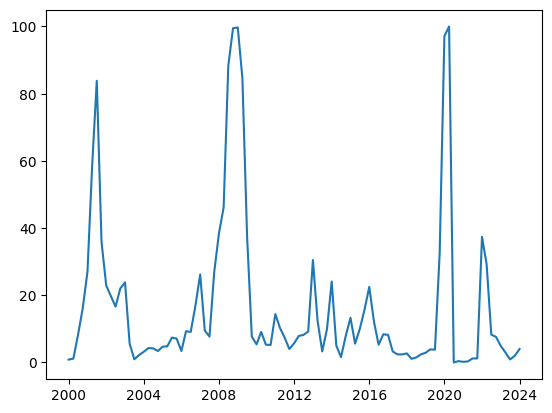

C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3603618892.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["recession"].iloc[i] = 1
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3603618892.py:24: SettingWithCopyWarning: 
A value 

In [31]:
recession_indicator_index = fred.get_series(series_id='JHGDPBRINDX', observation_start = '2000-01-01', observation_end='2024-01-01')
plt.figure()
plt.plot(recession_indicator_index)
plt.show()

recession_indicator_index = recession_indicator_index.copy()
recession_indicator_index = recession_indicator_index.to_frame(name='index')
recession_indicator_index.index = pd.to_datetime(recession_indicator_index.index)
recession_indicator_index = recession_indicator_index.resample('D').ffill()

def label_recessions(df):
    df = df.copy()
    df["recession"] = 0
    
    in_recession = False
    
    for i in range(len(df)):
        value = df["index"].iloc[i]
        
        if not in_recession:
            # recession starts
            if value > 67:
                in_recession = True
                df["recession"].iloc[i] = 1
        else:
            # currently in recession
            df["recession"].iloc[i] = 1
            
            # recession ends
            if value < 33:
                in_recession = False
    
    return df

fred_rec = label_recessions(recession_indicator_index)

In [32]:
fred_rec

,index,recession
2000-01-01,0.8612,0
2000-01-02,0.8612,0
2000-01-03,0.8612,0
2000-01-04,0.8612,0
2000-01-05,0.8612,0
...,...,...
2023-12-28,2.0000,0
2023-12-29,2.0000,0
2023-12-30,2.0000,0
2023-12-31,2.0000,0


In [33]:
fred_rec = fred_rec.reset_index()
fred_rec.columns = ['Date', 'index', 'recession']

# Make sure Date is datetime
fred_rec['Date'] = pd.to_datetime(fred_rec['Date'])
fred_rec.set_index('Date')

,index,recession
Date,,
2000-01-01,0.8612,0
2000-01-02,0.8612,0
2000-01-03,0.8612,0
2000-01-04,0.8612,0
2000-01-05,0.8612,0
...,...,...
2023-12-28,2.0000,0
2023-12-29,2.0000,0
2023-12-30,2.0000,0


In [34]:
def seperate_by_recession(results, recession):
    common_dates = results.index.intersection(recession.index)
    
    if len(common_dates) == 0:
        print("WARNING: No overlapping dates between results and recession!")
        return results.copy(), pd.DataFrame()
    
    # Filter regimes untuk tanggal yang ada di results
    recession_regimes = recession.loc[common_dates]
    
    # Separate
    non_recession_dates = recession_regimes[recession_regimes == 0].index
    recession_dates = recession_regimes[recession_regimes == 1].index
    
    non_recession_dates = results.loc[non_recession_dates].copy()
    recession_dates = results.loc[recession_dates].copy()
    
    print(f"\nFound {len(non_recession_dates)} non recession days")
    print(f"Found {len(recession_dates)} recession days")
    print(f"Total: {len(non_recession_dates) + len(recession_dates)} days")
    
    return recession_dates, non_recession_dates

In [35]:
def analyze_by_regime(recession_dates, non_recession_dates):
    """
    Analisis performance untuk masing-masing regime
    """
    print("\n" + "="*70)
    print("REGIME ANALYSIS - WALK-FORWARD RESULTS")
    print("="*70)
    
    total_days = len(non_recession_dates) + len(recession_dates)
    print(f"\nNon-Recession Days:  {len(non_recession_dates):>6} ({len(non_recession_dates)/total_days*100:>5.1f}%)")
    print(f"Recession Days: {len(recession_dates):>6} ({len(recession_dates)/total_days*100:>5.1f}%)")
    
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Non-Recession':>15} {'Recession':>15}")
    print("-"*70)
    
    # Low Vol Stats
    if len(non_recession_dates) > 0:
        low_strat_ret = non_recession_dates['strategy_ret'].mean() * 252 * 100
        low_strat_vol = non_recession_dates['strategy_ret'].std() * np.sqrt(252) * 100
        low_strat_sharpe = non_recession_dates['strategy_ret'].mean() / non_recession_dates['strategy_ret'].std() * np.sqrt(252) if non_recession_dates['strategy_ret'].std() > 0 else 0
        low_bh_ret = non_recession_dates['ret'].mean() * 252 * 100
        low_bh_vol = non_recession_dates['ret'].std() * np.sqrt(252) * 100
        low_bh_sharpe = non_recession_dates['ret'].mean() / non_recession_dates['ret'].std() * np.sqrt(252) if non_recession_dates['ret'].std() > 0 else 0
        low_win = (non_recession_dates['strategy_ret'] > 0).sum() / len(non_recession_dates) * 100
        low_strat_total = (1 + non_recession_dates['strategy_ret']).prod() - 1
        low_bh_total = (1 + non_recession_dates['ret']).prod() - 1
    else:
        low_strat_ret = low_strat_vol = low_strat_sharpe = 0
        low_bh_ret = low_bh_vol = low_bh_sharpe = low_win = 0
        low_strat_total = low_bh_total = 0
    
    # High Vol Stats
    if len(recession_dates) > 0:
        high_strat_ret = recession_dates['strategy_ret'].mean() * 252 * 100
        high_strat_vol = recession_dates['strategy_ret'].std() * np.sqrt(252) * 100
        high_strat_sharpe = recession_dates['strategy_ret'].mean() / recession_dates['strategy_ret'].std() * np.sqrt(252) if recession_dates['strategy_ret'].std() > 0 else 0
        high_bh_ret = recession_dates['ret'].mean() * 252 * 100
        high_bh_vol = recession_dates['ret'].std() * np.sqrt(252) * 100
        high_bh_sharpe = recession_dates['ret'].mean() / recession_dates['ret'].std() * np.sqrt(252) if recession_dates['ret'].std() > 0 else 0
        high_win = (recession_dates['strategy_ret'] > 0).sum() / len(recession_dates) * 100
        high_strat_total = (1 + recession_dates['strategy_ret']).prod() - 1
        high_bh_total = (1 + recession_dates['ret']).prod() - 1
    else:
        high_strat_ret = high_strat_vol = high_strat_sharpe = 0
        high_bh_ret = high_bh_vol = high_bh_sharpe = high_win = 0
        high_strat_total = high_bh_total = 0
    
    print(f"{'Total Return (Strategy)':<35} {low_strat_total*100:>14.2f}% {high_strat_total*100:>14.2f}%")
    print(f"{'Total Return (Buy&Hold)':<35} {low_bh_total*100:>14.2f}% {high_bh_total*100:>14.2f}%")
    print(f"{'Ann. Return (Strategy)':<35} {low_strat_ret:>14.2f}% {high_strat_ret:>14.2f}%")
    print(f"{'Ann. Return (Buy&Hold)':<35} {low_bh_ret:>14.2f}% {high_bh_ret:>14.2f}%")
    print(f"{'Ann. Volatility (Strategy)':<35} {low_strat_vol:>14.2f}% {high_strat_vol:>14.2f}%")
    print(f"{'Ann. Volatility (Buy&Hold)':<35} {low_bh_vol:>14.2f}% {high_bh_vol:>14.2f}%")
    print(f"{'Sharpe Ratio (Strategy)':<35} {low_strat_sharpe:>15.2f} {high_strat_sharpe:>15.2f}")
    print(f"{'Sharpe Ratio (Buy&Hold)':<35} {low_bh_sharpe:>15.2f} {high_bh_sharpe:>15.2f}")
    print(f"{'Win Rate (Strategy)':<35} {low_win:>14.2f}% {high_win:>14.2f}%")
    
    print("="*70)

    

In [36]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

models = {}
all_results = {}

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    all_results[ticker] = results
    market_ret = results['ret']
    # Fit on in-sample window
    model = MarkovRegression(
        market_ret,
        k_regimes=2,
        trend="c",
        switching_variance=True
    )

    models[ticker] = model.fit()
    


C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\3073231086.py:70: FutureWarning: A valu

In [37]:
all_results['SPY']

Price,signal,strategy_ret,ret
Date,,,
2003-01-03,0.0,0.0,0.003075
2003-01-06,0.0,0.0,0.017625
2003-01-07,0.0,-0.0,-0.002474
2003-01-08,0.0,-0.0,-0.014451
2003-01-09,0.0,0.0,0.015538
...,...,...,...
2022-12-23,0.0,0.0,0.005752
2022-12-27,0.0,-0.0,-0.003944
2022-12-28,0.0,-0.0,-0.012428


In [38]:
for ticker in asset_list:
    print(f"\n{'='*70}")
    print(f"ASSET: {ticker}")
    print(f"{'='*70}")
    
    # Separate and analyze
    results = all_results[ticker]
    recession_dates, non_recession_dates = seperate_by_recession(results, fred_rec)
    analyze_by_regime(recession_dates, non_recession_dates)


ASSET: SPY

REGIME ANALYSIS - WALK-FORWARD RESULTS

Non-Recession Days:       0 (  0.0%)
Recession Days:   5034 (100.0%)

----------------------------------------------------------------------
Metric                                Non-Recession       Recession
----------------------------------------------------------------------
Total Return (Strategy)                       0.00%          -4.27%
Total Return (Buy&Hold)                       0.00%         516.35%
Ann. Return (Strategy)                        0.00%          -0.18%
Ann. Return (Buy&Hold)                        0.00%          10.93%
Ann. Volatility (Strategy)                    0.00%           2.69%
Ann. Volatility (Buy&Hold)                    0.00%          19.11%
Sharpe Ratio (Strategy)                        0.00           -0.07
Sharpe Ratio (Buy&Hold)                        0.00            0.57
Win Rate (Strategy)                           0.00%           1.97%

ASSET: QQQ

REGIME ANALYSIS - WALK-FORWARD RESULTS

No

In [39]:
for ticker in asset_list:
    print(f"\n{'='*70}")
    print(f"ASSET: {ticker}")
    print(f"{'='*70}")
    
    # Get regime from that asset's model
    regime = models[ticker].smoothed_marginal_probabilities.idxmax(axis=1)
    
    # Separate and analyze
    results = all_results[ticker]
    low_vol, high_vol = seperate_by_regimes(results, regime)
    analyze_by_regime(low_vol, high_vol)


ASSET: SPY

Found 3671 low volatility days
Found 1363 high volatility days
Total: 5034 days

REGIME ANALYSIS - WALK-FORWARD RESULTS

Non-Recession Days:    1363 ( 27.1%)
Recession Days:   3671 ( 72.9%)

----------------------------------------------------------------------
Metric                                Non-Recession       Recession
----------------------------------------------------------------------
Total Return (Strategy)                      17.92%         -18.81%
Total Return (Buy&Hold)                     -77.60%        2651.82%
Ann. Return (Strategy)                        3.11%          -1.41%
Ann. Return (Buy&Hold)                      -22.44%          23.33%
Ann. Volatility (Strategy)                    3.65%           2.23%
Ann. Volatility (Buy&Hold)                   32.27%          10.59%
Sharpe Ratio (Strategy)                        0.85           -0.63
Sharpe Ratio (Buy&Hold)                       -0.70            2.20
Win Rate (Strategy)                       

In [40]:
import statsmodels.api as sm

def newey_west_alpha_test(res):
    y = res['strategy_ret'] - res['ret']      # strategy excess over market
    X = np.ones(len(y))                       # constant only
    model = sm.OLS(y, X)
    nw = model.fit(cov_type='HAC', cov_kwds={'maxlags':5})
    return nw.tvalues[0], nw.pvalues[0]

for ticker in asset_list:
    results = all_results[ticker]
    t_values, p_values = newey_west_alpha_test(results)
    print(f"{ticker} t_values = {t_values}")
    print(f"{ticker} p_values = {p_values}")
    print("=" * 70)

SPY t_values = -2.8495235973821256
SPY p_values = 0.0043784757652203035
QQQ t_values = -3.460341347983909
QQQ p_values = 0.0005394910335553111
DIA t_values = -2.97547308097126
DIA p_values = 0.002925370235282651
EWJ t_values = -1.5237726301444534
EWJ p_values = 0.1275655188934982
EEM t_values = -0.9972226742555548
EEM p_values = 0.3186564373561802
VGK t_values = -1.0501760160059017
VGK p_values = 0.2936371943575169
TLT t_values = -1.4627421922395016
TLT p_values = 0.14353793637403478
IEF t_values = -2.0898162649972414
IEF p_values = 0.036634307704245375
BND t_values = -1.7923027916962693
BND p_values = 0.07308447635711313
GLD t_values = -1.6048119741030291
GLD p_values = 0.10853519001295416
SLV t_values = -0.6109677960130655
SLV p_values = 0.5412209003723385
USO t_values = 0.04165716411527618
USO p_values = 0.9667720023811269
EURUSD=X t_values = 0.17154243019373785
EURUSD=X p_values = 0.8637972703907189
JPY=X t_values = -0.7062408856169239
JPY=X p_values = 0.48003834842589654
AUDUSD=X 

C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pva

In [41]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    return {
        'adf_p': adfuller(series.dropna())[1],
        'kpss_p': kpss(series.dropna(), nlags='auto')[1]
    }

for ticker in asset_list:
    results = all_results[ticker]
    adf_p, kpps_p = newey_west_alpha_test(results)
    print(f"{ticker} adf p_value = {adf_p}")
    print(f"{ticker} kpps p_value = {kpps_p}")
    print("=" * 70)

SPY adf p_value = -2.8495235973821256
SPY kpps p_value = 0.0043784757652203035
QQQ adf p_value = -3.460341347983909
QQQ kpps p_value = 0.0005394910335553111
DIA adf p_value = -2.97547308097126
DIA kpps p_value = 0.002925370235282651
EWJ adf p_value = -1.5237726301444534
EWJ kpps p_value = 0.1275655188934982
EEM adf p_value = -0.9972226742555548
EEM kpps p_value = 0.3186564373561802
VGK adf p_value = -1.0501760160059017
VGK kpps p_value = 0.2936371943575169
TLT adf p_value = -1.4627421922395016
TLT kpps p_value = 0.14353793637403478
IEF adf p_value = -2.0898162649972414
IEF kpps p_value = 0.036634307704245375
BND adf p_value = -1.7923027916962693
BND kpps p_value = 0.07308447635711313
GLD adf p_value = -1.6048119741030291
GLD kpps p_value = 0.10853519001295416
SLV adf p_value = -0.6109677960130655
SLV kpps p_value = 0.5412209003723385
USO adf p_value = 0.04165716411527618
USO kpps p_value = 0.9667720023811269
EURUSD=X adf p_value = 0.17154243019373785
EURUSD=X kpps p_value = 0.863797270

C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_9032\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pva

In [42]:
import numpy as np
from scipy.stats import norm

def ledoit_wolf_sharpe_test(r1, r2):
    n = len(r1)
    mean1, mean2 = np.mean(r1), np.mean(r2)
    std1, std2  = np.std(r1, ddof=1), np.std(r2, ddof=1)

    sharpe1, sharpe2 = mean1/std1, mean2/std2
    diff = sharpe1 - sharpe2

    # LW correction components
    term1 = (mean1**2 / (2 * std1**4)) * np.var((r1 - mean1)**2)
    term2 = (mean2**2 / (2 * std2**4)) * np.var((r2 - mean2)**2)
    var_diff = term1 + term2

    z = diff / np.sqrt(var_diff / n)
    p = 1 - norm.cdf(z)  # one-sided test: is Sharpe1 > Sharpe2?

    return sharpe1, sharpe2, diff, z, p

for ticker in asset_list:
    results = all_results[ticker]
    s1, s2, diff, z, p = ledoit_wolf_sharpe_test(results['strategy_ret'], results['ret'])
    print(f'p value for {ticker} = {p}')

p value for SPY = 1.0
p value for QQQ = 1.0
p value for DIA = 1.0
p value for EWJ = 1.0
p value for EEM = 0.0
p value for VGK = 1.0
p value for TLT = 1.0
p value for IEF = 1.0
p value for BND = 1.0
p value for GLD = 1.0
p value for SLV = 1.0
p value for USO = 1.0
p value for EURUSD=X = 0.0
p value for JPY=X = 1.0
p value for AUDUSD=X = 0.0
p value for BTC-USD = 1.0
p value for ETH-USD = 1.0


Regime-dependent performance, risk-adjusted excess returns, and causality once non-stationarity/autocorrelation are controlled.

In [43]:
import numpy as np

def bootstrap_significance(strategy_returns, n_boot=5000):
    actual_mean = np.mean(strategy_returns)

    boot_means = []
    for _ in range(n_boot):
        random_sign = np.random.choice([-1, 1], size=len(strategy_returns))
        boot_means.append(np.mean(strategy_returns * random_sign))

    p_value = np.mean(np.array(boot_means) >= actual_mean)
    return actual_mean, np.mean(boot_means), p_value

for ticker in asset_list:
    results = all_results[ticker]
    actual_mean, boot_mean, p_value = bootstrap_significance(results['strategy_ret'])
    print(f'{ticker} p_value = {p_value}')


SPY p_value = 0.617
QQQ p_value = 0.846
DIA p_value = 0.8292
EWJ p_value = 0.3488
EEM p_value = 0.0806
VGK p_value = 0.4344
TLT p_value = 0.7158
IEF p_value = 0.475
BND p_value = 0.5874
GLD p_value = 0.6296
SLV p_value = 0.1508
USO p_value = 0.6552
EURUSD=X p_value = 0.5068
JPY=X p_value = 0.8188
AUDUSD=X p_value = 0.3928
BTC-USD p_value = 0.8232
ETH-USD p_value = 0.3276


p < 0.05 → your strategy beats randomness

p > 0.05 → your “edge” disappears once randomness is modeled